In [1]:
import numpy as np
from scipy import linalg, special, sparse
import sympy
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import cvxpy as cp
import copy
import requests
import xmltodict


sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

# Import simulation output

In [2]:
time = '10'
date = '2023-03-08'
experiment = 'balance-fix'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [3]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [4]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [5]:
stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8"] # generate carbon mistake in parca, efflux/influx proton gen, iron cheating
for rxn in bad_rxns:
    stoichiometry.pop(rxn, None)


In [6]:
stoichiometry['1.1.1.127-RXN']

{'2-DEHYDRO-3-DEOXY-D-GLUCONATE[c]': -1,
 'NAD[c]': -1,
 'CPD-343[c]': 1,
 'NADH[c]': 1,
 'PROTON[c]': 1}

Pandas automatically understands dicts of dicts as matrices. 

In [7]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

,4
ATPSYN-RXN (reverse),1509759
TRANS-RXN0-547[CCO-PM-BAC-NEG]-WATER//WATER.29.,905893
SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN-SUC/UBIQUINONE-8//FUM/CPD-9956.31.,857780
R601-RXN-FUM/REDUCED-MENAQUINONE//SUC/CPD-9728.38.,700754
RXN0-5388-CPD-9728/NADH/PROTON//REDUCED-MENAQUINONE/NAD/PROTON.53.,699206
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),468395
FUMHYDR-RXN__FUMARASE-A,449687
TRANS-RXN0-474,433303
RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.,433255
GAPOXNPHOSPHN-RXN,384822


# Change nutrient composition

In [8]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set(
    [
        # "D-Ribopyranose[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
    ]
)
removals = set(
                [
               #    "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
                ]
                )


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'GLC[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

In [9]:
Sd = pd.DataFrame(stoichiometry, dtype=np.int8).fillna(0).astype(np.int8)


In [10]:
#stoich_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}

mets_df = pd.DataFrame(Sd.index, columns=["Name"]) # index to name
rxns_df = pd.DataFrame(Sd.columns, columns=["Name"]) 

exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"])
maintenance = pd.DataFrame(fba["target_maintenance_flux"])

kinetic = pd.DataFrame(fba["target_kinetic_fluxes"])
kin_rxns = list(kinetic.keys())

homeostatic_mets = list(homeostatic.keys())
exchange_mets = list(exchanges.keys())
intermediate_mets = list(set(mets_df["Name"]) - set(homeostatic.keys()))

n_mets, n_orig_rxns = Sd.shape

exchange_mets.extend(list(uptake))

Se = pd.DataFrame(index=Sd.index)

for met in exchange_mets:
    exch_name = met + " exchange"
    if met in uptake:
        Se[exch_name] = np.zeros(n_mets).astype(np.int8)
        Se.at[met, exch_name] = 1
    
    Se[exch_name + " rev"] = np.zeros(n_mets).astype(np.int8)
    Se.at[met, exch_name + " rev"] = -1
      
    
    
S_orig = np.array(Sd, dtype=np.float64)
S_exch = np.array(Se, dtype=np.float64)

_, n_exch_rxns = S_exch.shape


int_df = mets_df[mets_df['Name'].isin(intermediate_mets)].reset_index()
int_idx = list(int_df["index"])

hom_df = mets_df[mets_df['Name'].isin(homeostatic_mets)].reset_index()
target_hom = pd.DataFrame(homeostatic.loc[4, :]).reset_index(drop=False)
target_hom.columns = ["Name", "Count"]
merge_df = hom_df.set_index('Name').join(target_hom.set_index('Name'))

kin_df = rxns_df[rxns_df['Name'].isin(kin_rxns)].reset_index()
target_kin = pd.DataFrame(kinetic.loc[4, :]).reset_index(drop=False)
target_kin.columns = ["Name", "Flux"]
merge_kin_df = kin_df.set_index('Name').join(target_kin.set_index('Name'))

v_hom = np.array(merge_df["Count"]).astype(np.float64)
hom_idx = np.array(merge_df["index"]).astype(np.int64)

v_kin = np.array(merge_kin_df["Flux"]).astype(np.float64)
kin_idx = np.array(merge_kin_df["index"]).astype(np.int64)

v_main = np.array(fba["target_maintenance_flux"][4])
main_idx = list(Sd.columns).index("maintenance_reaction")


secretion_idx = np.where(S_exch.sum(axis=0) == -1)[0]

In [11]:
v = cp.Variable(n_orig_rxns)
e = cp.Variable(n_exch_rxns)
v_t = cp.hstack([v,e])
dm = S_orig @ v + S_exch @ e 


constr = []
constr.append(dm[int_idx] == 0)
constr.append(v[main_idx] == v_main)
# constr.append(dm[hom_idx] == v_hom)
constr.extend([v >= 0, v <= 100000000, e >= 0, e <= 100000000])

loss = 0
loss += cp.norm1(dm[hom_idx] - v_hom)
loss += 0.001*(cp.sum(e[secretion_idx]))
loss += 0.00001*(cp.sum(v))
loss += 0.000001 * cp.norm1(v[kin_idx] - v_kin)

In [12]:
p = cp.Problem(
        cp.Minimize(loss),
    constr
    )
               
p.solve(solver=cp.GLOP, verbose=False)

1408.8400771785082

# Analyze output

In [13]:
exchange_rxns = Se.columns
exchange_nb = pd.DataFrame({exchange_rxns[i]: [e.value[i]] for i in range(len(exchange_rxns))}).sort_values(by=0, axis=1, ascending=False).T
exchange_nb = exchange_nb[exchange_nb[0] != 0]
index_raw = list(exchange_nb.index.str.split())
index_cleaned = [index_raw[i][0] for i in range(len(index_raw))]
exchange_nb.index = index_cleaned
exchange_nb.columns = ["Exchange flux"]
exchange_nb.head(5)

,Exchange flux
WATER[p],4.493609e+06
CARBON-DIOXIDE[p],1.006485e+06
AMMONIUM[c],8.870805e+05
OXYGEN-MOLECULE[p],8.661753e+05
GLC[p],7.532153e+05


In [14]:
exchange_sim = pd.DataFrame(exchanges.loc[4, :].abs().sort_values())
exchange_sim = exchange_sim[exchange_sim[4] != 0]
exchange_sim.columns = ["Exchange flux"]
exchange_sim.head(5)

,Exchange flux
S-ADENOSYL-4-METHYLTHIO-2-OXOBUTANOATE[c],4
METOH[p],4
L-SELENOCYSTEINE[c],7
CPD-1772[c],14
CPD-108[p],16


In [15]:
exch_comp = pd.merge(exchange_nb, exchange_sim, left_index=True, right_index=True, suffixes=(' new', ' standard'), how='outer').fillna(0).astype(np.int64)
exch_comp.sort_values(by="Exchange flux new", ascending=False).head()

,Exchange flux new,Exchange flux standard
WATER[p],4493608,3625912
CARBON-DIOXIDE[p],1006485,1873581
AMMONIUM[c],887080,887279
OXYGEN-MOLECULE[p],866175,1733230
GLC[p],753215,897920


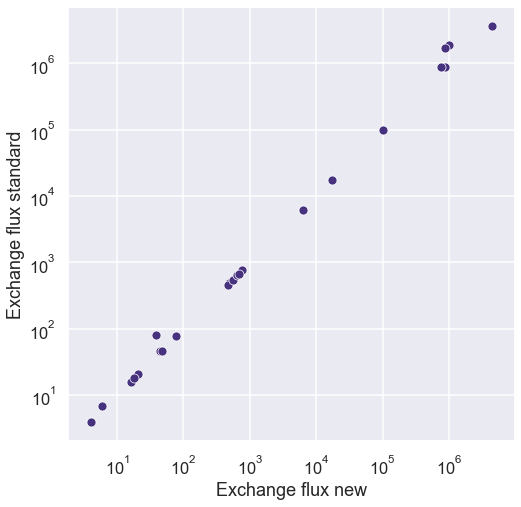

In [16]:
plt.figure(figsize=[8,8])

sns.scatterplot(x="Exchange flux new", y="Exchange flux standard", data=exch_comp)
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')

In [17]:
flux_indexed = list(Sd.columns[:n_orig_rxns])
fluxes = pd.DataFrame({flux_indexed[i]: [v.value[i], stoichiometry[flux_indexed[i]]] for i in range(len(flux_indexed))}).T
fluxes.sort_values(by=0, axis=0, ascending=False).head(15)

,0,1
TRANS-RXN-145,4493608.956661,"{'WATER[p]': -1, 'WATER[c]': 1}"
ATPSYN-RXN (reverse),3189029.242245,"{'ATP[c]': 1, 'WATER[c]': 1, 'PROTON[c]': 3, '..."
maintenance_reaction,1898967.604471,"{'ATP[c]': -1, 'WATER[c]': -1, 'ADP[c]': 1, 'P..."
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.,1487950.905566,"{'NADH[c]': -1, 'UBIQUINONE-8[i]': -1, 'PROTON..."
GAPOXNPHOSPHN-RXN,1250954.681113,"{'GAP[c]': -1, 'NAD[c]': -1, 'Pi[c]': -1, 'DPG..."
PHOSGLYPHOS-RXN (reverse),1250952.681113,"{'G3P[c]': 1, 'ATP[c]': 1, 'DPG[c]': -1, 'ADP[..."
3PGAREARR-RXN (reverse),1120153.681113,"{'2-PG[c]': 1, 'G3P[c]': -1}"
2PGADEHYDRAT-RXN,1120137.681113,"{'2-PG[c]': -1, 'PHOSPHO-ENOL-PYRUVATE[c]': 1,..."
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),1006485.043339,"{'CARBON-DIOXIDE[p]': 1, 'CARBON-DIOXIDE[c]': -1}"
TRANS-RXN0-474,866158.293339,"{'OXYGEN-MOLECULE[p]': -1, 'OXYGEN-MOLECULE[c]..."


In [18]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

,4
ATPSYN-RXN (reverse),1509759
TRANS-RXN0-547[CCO-PM-BAC-NEG]-WATER//WATER.29.,905893
SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN-SUC/UBIQUINONE-8//FUM/CPD-9956.31.,857780
R601-RXN-FUM/REDUCED-MENAQUINONE//SUC/CPD-9728.38.,700754
RXN0-5388-CPD-9728/NADH/PROTON//REDUCED-MENAQUINONE/NAD/PROTON.53.,699206
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),468395
FUMHYDR-RXN__FUMARASE-A,449687
TRANS-RXN0-474,433303
RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.,433255
GAPOXNPHOSPHN-RXN,384822


In [19]:
exchanges.loc[4,:].abs().sort_values(ascending=False).head(10)

WATER[p]              3625912
CARBON-DIOXIDE[p]     1873581
OXYGEN-MOLECULE[p]    1733230
GLC[p]                 897920
AMMONIUM[c]            887279
PROTON[p]              775061
Pi[p]                  100667
K+[p]                   17424
SULFATE[p]               6263
MG+2[p]                   774
Name: 4, dtype: int64

In [20]:
dmdt_indexed = list(Sd.index)
# hom_idx
dmdt_dict = {dmdt_indexed[i]: [dm.value[i], v_hom[j], dm.value[i] - v_hom[j]] for j, i in enumerate(hom_idx)}
dmdt = pd.DataFrame(dmdt_dict).sort_values(by=0, axis=1).T
dmdt
#dmdt = pd.DataFrame({dmdt_indexed[i]: [dm.value[i], v_hom[j]] for j, i in enumerate(hom_idx)})
#dmdt.sort_values(by=0, axis=1, ascending=False).T.head(20)

,0,1,2
PPI[c],-78147.0,-78147.0,-7.275958e-11
PROTON[c],-17999.0,-17999.0,3.725290e-09
GMP[c],-4851.0,-4851.0,7.275958e-12
AMP[c],-4531.0,-4531.0,-2.728484e-11
CMP[c],-4307.0,-4307.0,0.000000e+00
...,...,...,...
VAL[c],34446.0,34446.0,0.000000e+00
GLY[c],34610.0,34610.0,1.455192e-11
LEU[c],36085.0,36085.0,0.000000e+00
L-ALPHA-ALANINE[c],43678.0,43678.0,-7.275958e-12


In [21]:
mets_df[mets_df.loc[:, "Name"].str.contains("FUM")]

,Name
576,FUM[c]
3678,FUM[p]
4506,FUM[e]


# Set up schema for testing lots of fluxes

## Connect to EcoCyc to go from Genes -> Reactions

In [22]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [34]:
condition_sets = {0: {"Environment": "Hydrogen + fumarate, -O2, -Glc",
                      "Genes": set(["EG10468", "EG10469", "EG10470", "EG11799", "EG11800", "EG11801", "G7554"]), 
                      "Add": set(["FUM[p]", 'HYDROGEN-MOLECULE[p]']),
                      "Remove": set(["GLC[p]", "OXYGEN-MOLECULE[p]"]),
                      },
                  
                  1: {"Environment": "Ribose C-source",
                      "Genes": set(["EG10814", "EG10815", "EG10816", "EG10818"]), 
                      "Add": set(["D-Ribopyranose[p]"]),
                      "Remove": set(["GLC[p]"]),
                      },
                  
                  2: {"Environment": "Thiamine salvaging",
                      "Genes": set(["EG11574", "G6566", "M007", "EG11573", "EG11572"]), 
                      "Add": set(["THIAMINE[p]"]),
                      "Remove": set(),
                      },
                  
                  3: {"Environment": "Nitrate as reduction target",
                      "Genes": set(["EG10638", "EG10639", "EG10640", "EG10644", "EG10647", "EG10648"]), 
                      "Add": set(["NITRATE[p]"]),
                      "Remove": set(["OXYGEN-MOLECULE[p]"]),
                      },
                  
                  4: {"Environment": "3-Phenylpropionate as carbon and energy source",
                      "Genes": set(["M010", "M011", "M012", "G6206"]), 
                      "Add": set(["3-PHENYLPROPIONATE[p]"]),
                      "Remove": set(["GLC[p]"]),
                      },
                  
                  # 5: {"Genes": set(["EG10286", "EG10287", "EG10288", "EG10289", 
                  #                   "EG10290", "EG10293", "EG10294", "EG10295", 
                  #                   "EG10296", "EG10298", "EG10302", "EG10303", 
                  #                   "EG10304", "EG10305", "EG10306", "G6414"]), 
                  #     "Add": set(),
                  #     "Remove": set(),
                  #     "Environment": "Proper metal (iron) uptake"}
                 }

condition_df = pd.DataFrame(condition_sets).T
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df

,Environment,Genes,Add,Remove,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{EG11799, EG11801, G7554, EG10469, EG10468, EG...","{FUM[p], HYDROGEN-MOLECULE[p]}","{OXYGEN-MOLECULE[p], GLC[p]}",[nan]
1,Ribose C-source,"{EG10814, EG10816, EG10815, EG10818}",{D-Ribopyranose[p]},{GLC[p]},[nan]
2,Thiamine salvaging,"{EG11573, EG11572, EG11574, G6566, M007}",{THIAMINE[p]},{},[nan]
3,Nitrate as reduction target,"{EG10639, EG10648, EG10640, EG10638, EG10644, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},[nan]
4,3-Phenylpropionate as carbon and energy source,"{M011, M012, M010, G6206}",{3-PHENYLPROPIONATE[p]},{GLC[p]},[nan]


In [48]:
for i in range(len(condition_df.index)):
    
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
        if type(o) is dict:
            o = [o]
        
        for rxn in o:
            if type(rxn) is not str: # no rxns
                rxn_set.add(rxn['@frameid'])
            else:
                print(gene, rxn)
            
    condition_df.at[i, "Reactions"] = rxn_set

In [50]:
xmltodict.parse(r.content)

{'ptools-xml': {'@ptools-version': '26.5',
  '@xml:base': 'http://BioCyc.org/apixml?fn=reactions-of-gene%26id=ECOLI:G6206%26detail=NONE',
  'metadata': {'url': 'http://BioCyc.org/',
   'service_name': 'apixml',
   'query': 'fn=reactions-of-gene&id=ECOLI:G6206&detail=NONE',
   'num_results': '2'},
  'Reaction': [{'@resource': 'getxml?ECOLI:TRANS-RXN0-457',
    '@orgid': 'ECOLI',
    '@frameid': 'TRANS-RXN0-457'},
   {'@resource': 'getxml?ECOLI:TRANS-RXN-61',
    '@orgid': 'ECOLI',
    '@frameid': 'TRANS-RXN-61'}]}}

In [36]:
condition_df

,Environment,Genes,Add,Remove,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{EG11799, EG11801, G7554, EG10469, EG10468, EG...","{FUM[p], HYDROGEN-MOLECULE[p]}","{OXYGEN-MOLECULE[p], GLC[p]}","{RXN0-5256, RXN0-7399, RXN-16420}"
1,Ribose C-source,"{EG10814, EG10816, EG10815, EG10818}",{D-Ribopyranose[p]},{GLC[p]},"{ABC-28-RXN, RIBOKIN-RXN}"
2,Thiamine salvaging,"{EG11573, EG11572, EG11574, G6566, M007}",{THIAMINE[p]},{},"{RXN0-7298, THIKIN-RXN, ABC-32-RXN, THIAZOLSYN..."
3,Nitrate as reduction target,"{EG10639, EG10648, EG10640, EG10638, EG10644, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},"{RXN-15119, RXN0-7124, RXN0-3501}"
4,3-Phenylpropionate as carbon and energy source,"{M011, M012, M010, G6206}",{3-PHENYLPROPIONATE[p]},{GLC[p]},"{TRANS-RXN0-457, MHPHYDROXY-RXN, TRANS-RXN-61,..."


## Initialize FBA

In [26]:
#stoich_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}

mets_df = pd.DataFrame(Sd.index, columns=["Name"]) # index to name
rxns_df = pd.DataFrame(Sd.columns, columns=["Name"]) 

exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"])
maintenance = pd.DataFrame(fba["target_maintenance_flux"])

kinetic = pd.DataFrame(fba["target_kinetic_fluxes"])
kin_rxns = list(kinetic.keys())

homeostatic_mets = list(homeostatic.keys())
exchange_mets = list(exchanges.keys())
intermediate_mets = list(set(mets_df["Name"]) - set(homeostatic.keys()))

n_mets, n_orig_rxns = Sd.shape


int_df = mets_df[mets_df['Name'].isin(intermediate_mets)].reset_index()
int_idx = list(int_df["index"])

hom_df = mets_df[mets_df['Name'].isin(homeostatic_mets)].reset_index()
target_hom = pd.DataFrame(homeostatic.loc[4, :]).reset_index(drop=False)
target_hom.columns = ["Name", "Count"]
merge_df = hom_df.set_index('Name').join(target_hom.set_index('Name'))

kin_df = rxns_df[rxns_df['Name'].isin(kin_rxns)].reset_index()
target_kin = pd.DataFrame(kinetic.loc[4, :]).reset_index(drop=False)
target_kin.columns = ["Name", "Flux"]
merge_kin_df = kin_df.set_index('Name').join(target_kin.set_index('Name'))

v_hom = np.array(merge_df["Count"]).astype(np.float64)
hom_idx = np.array(merge_df["index"]).astype(np.int64)

v_kin = np.array(merge_kin_df["Flux"]).astype(np.float64)
kin_idx = np.array(merge_kin_df["index"]).astype(np.int64)

v_main = np.array(fba["target_maintenance_flux"][4])
main_idx = list(Sd.columns).index("maintenance_reaction")

## Quick and dirty loop (after init)

In [27]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])

for i in range(len(condition_df)):
    condition_idx = i

    uptake = (fba["unconstrained_molecules"][3]).copy()
    uptake_c = fba["constrained_molecules"]

    uptake.extend(list(uptake_c.keys()))
    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals
    uptake

    # just need to change exchanges.
    exchange_mets = list(exchanges.keys())
    exchange_mets.extend(list(uptake))

    Se = pd.DataFrame(index=Sd.index)

    for met in exchange_mets:
        exch_name = met + " exchange"
        if met in uptake:
            Se[exch_name] = np.zeros(n_mets).astype(np.int8)
            Se.at[met, exch_name] = 1

        Se[exch_name + " rev"] = np.zeros(n_mets).astype(np.int8)
        Se.at[met, exch_name + " rev"] = -1

    S_exch = np.array(Se, dtype=np.float64)

    _, n_exch_rxns = S_exch.shape

    secretion_idx = np.where(S_exch.sum(axis=0) == -1)[0]

    v = cp.Variable(n_orig_rxns)
    e = cp.Variable(n_exch_rxns)
    v_t = cp.hstack([v,e])
    dm = S_orig @ v + S_exch @ e 


    constr = []
    constr.append(dm[int_idx] == 0)
    constr.append(v[main_idx] == v_main)
    # constr.append(dm[hom_idx] == v_hom)
    constr.extend([v >= 0, v <= 100000000, e >= 0, e <= 100000000])

    loss = 0
    loss += cp.norm1(dm[hom_idx] - v_hom)
    loss += 0.001*(cp.sum(e[secretion_idx]))
    loss += 0.00001*(cp.sum(v))
    loss += 0.000001 * cp.norm1(v[kin_idx] - v_kin)

    p = cp.Problem(
            cp.Minimize(loss),
        constr
        )

    p.solve(solver=cp.GLOP, verbose=False)

    # Check flux
    flux_indexed = list(Sd.columns[:n_orig_rxns])
    fluxes = pd.DataFrame({flux_indexed[i]: [v.value[i], stoichiometry[flux_indexed[i]]] for i in range(len(flux_indexed))}).T
    fluxes.columns = ["Flux", "Stoichiometry"]

    relevant_rxns = condition_df.at[condition_idx, "Reactions"]
    relevant_rxn_idx = []

    for rxn in relevant_rxns:
        relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

    relevant_fluxes = fluxes.iloc[relevant_rxn_idx, :]
    
    relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes["Flux"] != 0].loc[:, "Flux"]
    
    for j, k in enumerate(relevant_nonzero_fluxes.index):
        results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))
    #print(condition_df.at[condition_idx, "Environment"],"\n" ,relevant_fluxes[relevant_fluxes["Flux"] != 0].loc[:, "Flux"], "\n")

In [28]:
results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df

,Environment,Reaction,Flux
0,"Hydrogen + fumarate, -O2, -Glc",RXN0-5256-CPD-9728/P,9.625052e+06
0,Ribose C-source,ABC-28-RXN-ATP/D-Rib,9.475935e+05
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,5.656970e+05
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,3.818965e+05
0,Thiamine salvaging,THIKIN-RXN,1.600000e+01
0,Thiamine salvaging,ABC-32-RXN,1.600000e+01
0,Nitrate as reduction target,RXN0-7124-NITRATE/CP,6.746300e+04
0,Nitrate as reduction target,RXN0-3501-NITRATE/RE,4.963257e+05
0,3-Phenylpropionate as carbon and energy source,1.13.11.16-RXN,5.747953e+05
0,3-Phenylpropionate as carbon and energy source,MHPCHYDROL-RXN,5.747953e+05


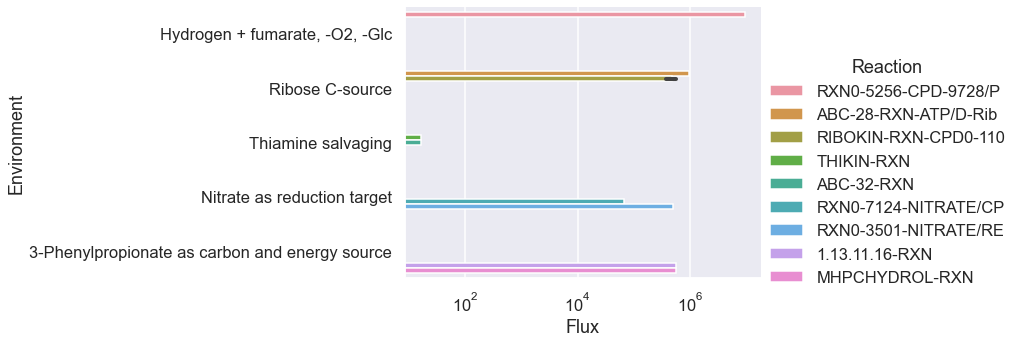

In [47]:
sns.catplot(y="Environment",hue="Reaction", x="Flux", data=results_df, kind="bar", aspect=2.5)
plt.xscale('log')
#plt.tight_layout()
plt.savefig("notebooks/fbagd/figures/rxns_light_up.png", dpi=300)

# Check metal reactions

In [30]:
# find mets containing
mets_df[mets_df.loc[:, "Name"].str.contains("FE\+2\[c\]")]

# find reactions containing met
reactions_id = Sd.loc[ "FE+2[c]", Sd.iloc[1092, :] != 0].index
reactions_id

Index(['PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54.',
       'PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54. (reverse)',
       'RXN-12540', 'RXN-12541', 'RXN-14960', 'RXN-15292', 'RXN-15293',
       'RXN-15294',
       'RXN0-1483[CCO-CYTOSOL]-FE+2/PROTON/OXYGEN-MOLECULE//FE+3/WATER.53.',
       'RXN0-2421', 'RXN0-6', 'RXN0-6555 (reverse)', 'RXN0-6941 (reverse)',
       'RXN0-7313 (reverse)', 'SIROHEME-FERROCHELAT-RXN', 'TRANS-RXN-424',
       'RXN0-949'],
      dtype='object')

In [31]:
# find reactions containing met
fluxes.loc[reactions_id,:]

,Flux,Stoichiometry
PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54.,-0.0,"{'PROTOHEME[c]': -1, 'PROTON[c]': -2, 'PROTOPO..."
PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54. (reverse),19.0,"{'PROTOHEME[c]': 1, 'PROTON[c]': 2, 'PROTOPORP..."
RXN-12540,-0.0,"{'HYDROGEN-PEROXIDE[c]': -1, 'FE+2[c]': -1, 'C..."
RXN-12541,-0.0,"{'FE+2[c]': -2, 'OXYGEN-MOLECULE[c]': -2, 'SUP..."
RXN-14960,-0.0,"{'Fe2-siderophores[c]': -1, 'PROTON[c]': -1, '..."
RXN-15292,-0.0,"{'FE+2[c]': -2, 'OXYGEN-MOLECULE[c]': -1, 'WAT..."
RXN-15293,-0.0,"{'FE+2[c]': -2, 'HYDROGEN-PEROXIDE[c]': -1, 'W..."
RXN-15294,-0.0,"{'FE+2[c]': -4, 'OXYGEN-MOLECULE[c]': -1, 'WAT..."
RXN0-1483[CCO-CYTOSOL]-FE+2/PROTON/OXYGEN-MOLECULE//FE+3/WATER.53.,-0.0,"{'FE+2[c]': -4, 'PROTON[c]': -4, 'OXYGEN-MOLEC..."
RXN0-2421,635.0,"{'FE+2[p]': -1, 'PROTON[p]': -1, 'FE+2[c]': 1,..."


# Troubleshoot wrong fluxes

In [32]:
top_wrong = fluxes_wrong.sort_values(by=0, axis=1, ascending=False).T.head(50)
top_right = fluxes.sort_values(by=0, axis=1, ascending=False).T.head(50)

top_wrong.join(top_right, lsuffix="wrong", rsuffix="right")

NameError: name 'fluxes_wrong' is not defined

In [ ]:
m2 = []

for rxn in ["LXULRU5P-RXN (reverse)", "RXN-21400", "RXN0-703 (reverse)", "RXN0-704", "RIBULPEPIM-RXN__EG12287-MONOMER", "RXN0-705__EG12285-MONOMER"]:
    m2.append({key: 2*value for key, value in stoichiometry[rxn].items()})
    
pd.DataFrame(m2, dtype=np.int8).fillna(0).astype(np.int8).sum(axis=0)

In [ ]:
m1 = []

for rxn in ["ALANINE-AMINOTRANSFERASE-RXN (reverse)", "MALATE-DEH-RXN (reverse)", "RXN-3523", "RXN-10981", \
 "RXN-12440", "CHD-RXN (reverse)", "RXN0-7230-CHOLINE/UBIQUINONE-8//BETAINE_ALDEHYDE/CPD-9956.48.", "ALARACECAT-RXN", "PMPOXI-RXN", "RXN0-5240"]:
    m1.append({key: value for key, value in stoichiometry[rxn].items()})
    
pd.DataFrame(m1, dtype=np.int8).fillna(0).astype(np.int8).sum(axis=0)

# Extract specific fluxes for balancing

In [ ]:
rxns_names = ['PGLUCISOM-RXN', '6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', 'TRIOSEPISOMERIZATION-RXN', 
              'GAPOXNPHOSPHN-RXN', 'PHOSGLYPHOS-RXN', '3PGAREARR-RXN',
              '2PGADEHYDRAT-RXN', 'PEPDEPHOS-RXN']

In [ ]:
fluxes.sort_values(by=0, axis=1, ascending=False).T.head(10)

In [ ]:
fluxes_small = fluxes.loc[fluxes.index.isin(rxns_names), :]
fluxes_small

In [ ]:
fluxes.loc[fluxes.index.str.contains("TRIOSEPISOMERIZATION-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("3PGAREARR-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("PHOSGLYPHOS-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("2TRANSKETO-RXN"),:]

# Glucose transport

In [51]:
glucose_transport_reactions = ['TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//ALPHA-GLC-6-P/PTSH-MONOMER.52.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//D-glucopyranose-6-phosphate/PTSH-MONOMER.66.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//GLC-6-P/PTSH-MONOMER.46.',
                               'RXN0-7077-GLC/PROTON//ALPHA-GLUCOSE/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//Glucopyranose/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//GLC/PROTON.23.',
                               'TRANS-RXN0-574-GLC//GLC.9.',
                               'TRANS-RXN0-574-GLC//Glucopyranose.19.',
                               'TRANS-RXN-320-GLC/ATP/WATER//ALPHA-GLUCOSE/ADP/Pi/PROTON.43.',
                               'TRANS-RXN-320-GLC/ATP/WATER//GLC/ADP/Pi/PROTON.33.',
                               'TRANS-RXN-320-GLC/ATP/WATER//Glucopyranose/ADP/Pi/PROTON.43.']
